In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

In [2]:
from google.colab import files
import zipfile
import os
import tensorflow as tf

uploaded = files.upload()

for fn in uploaded.keys():
    zip_path = f"/content/{fn}"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
    print(f'Extracted: {fn}')

base_path = "/content"
subfolders = [f.path for f in os.scandir(base_path) if f.is_dir()]
for path in subfolders:
    if len(os.listdir(path)) >= 2 and all(os.path.isdir(os.path.join(path, d)) for d in os.listdir(path)):
        dataset_dir = path
        break

print(f"Detected dataset directory: {dataset_dir}")

Saving archive.zip to archive (1).zip
Extracted: archive (1).zip
Detected dataset directory: /content/TrashType_Image_Dataset


In [3]:
image_size = (124, 124)
batch_size = 32
seed = 4

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [5]:
# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)
val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [6]:
val_batches=tf.data.experimental.cardinality(val_ds)
test_ds=val_ds.take(val_batches//2)
val_ds=val_ds.skip(val_batches//2)
test_ds_eval=test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


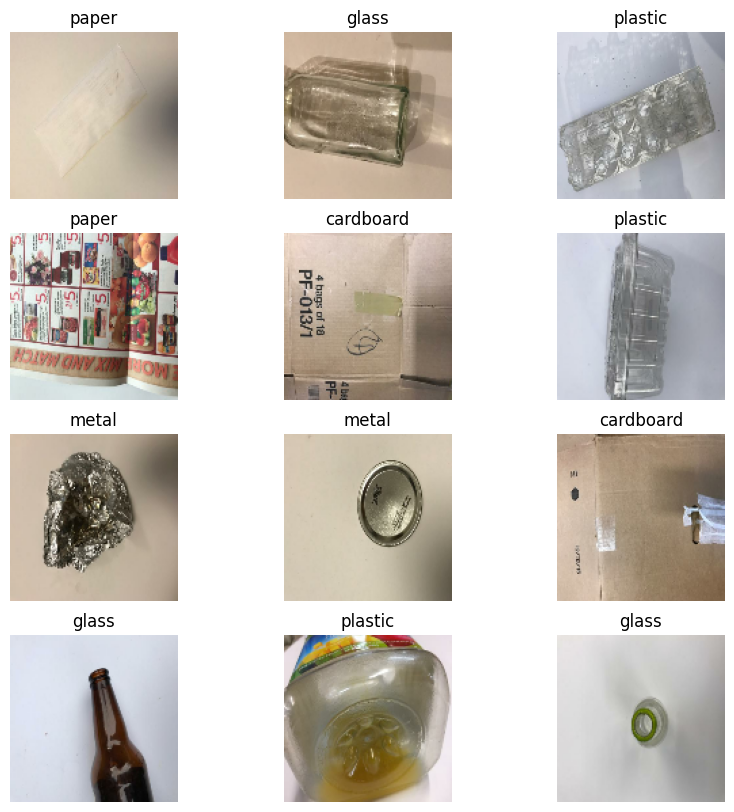

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(4, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [9]:
def count_distribution(dataset, class_names):
  total=0
  counts={name: 0 for name in class_names}
  for _, labels in dataset:
    for label in labels.numpy():
      class_name=class_names[label]
      counts[class_name]+=1
      total+=1

  for k in counts:
    counts[k]=round((counts[k]/total)*100, 2)
  return counts

In [10]:
def simple_bar_plot(dist, title):
  plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
  plt.title(title)
  plt.ylabel('percentage (%)')
  plt.xticks(rotation=45)
  plt.ylim(0, 100)
  plt.tight_layout()
  plt.show()

In [11]:
class_names=train_ds.class_names
train_dist=count_distribution(train_ds, class_names)
val_dist=count_distribution(val_ds, class_names)
test_dist=count_distribution(test_ds, class_names)
overall_dist={}
for k in class_names:
  overall_dist[k]=round((train_dist[k]+val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 15.23, 'glass': 20.23, 'metal': 16.52, 'paper': 23.05, 'plastic': 19.49, 'trash': 5.49}
{'cardboard': 18.47, 'glass': 17.27, 'metal': 17.27, 'paper': 24.5, 'plastic': 14.46, 'trash': 8.03}
{'cardboard': 18.36, 'glass': 22.27, 'metal': 12.89, 'paper': 22.27, 'plastic': 19.53, 'trash': 4.69}
{'cardboard': 16.85, 'glass': 18.75, 'metal': 16.89, 'paper': 23.77, 'plastic': 16.98, 'trash': 6.76}


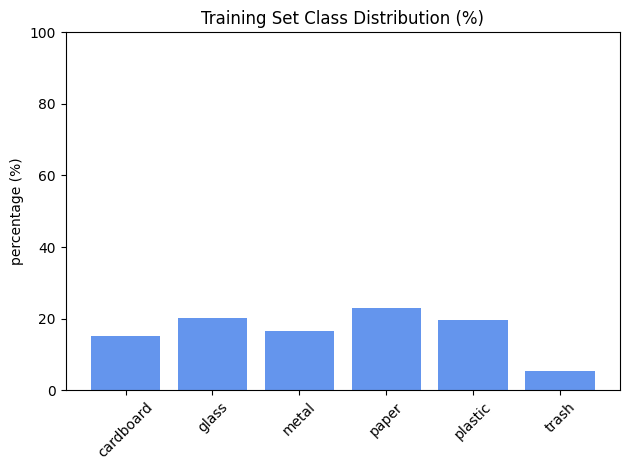

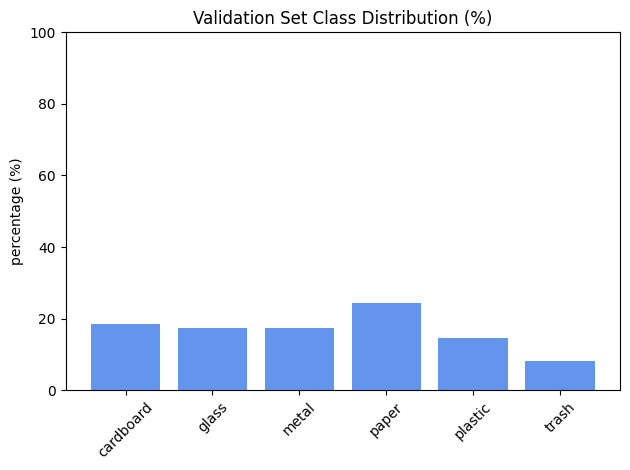

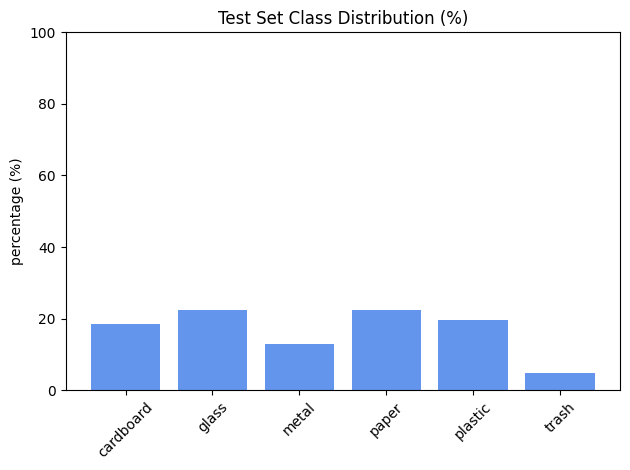

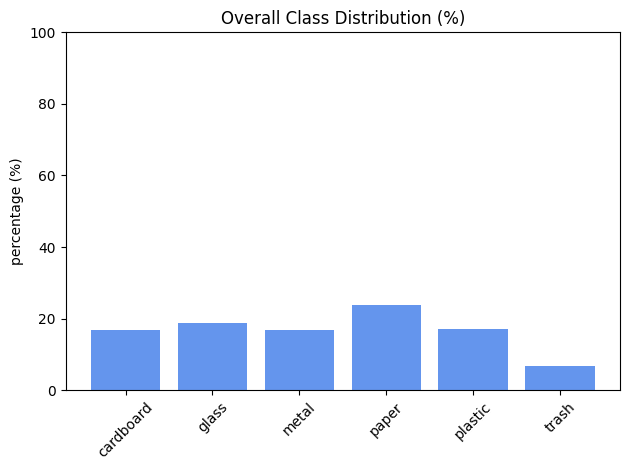

In [12]:
simple_bar_plot(train_dist, 'Training Set Class Distribution (%)')
simple_bar_plot(val_dist, 'Validation Set Class Distribution (%)')
simple_bar_plot(test_dist, 'Test Set Class Distribution (%)')
simple_bar_plot(overall_dist, 'Overall Class Distribution (%)')

In [13]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
  for label in labels.numpy():
    class_counts[label]+=1
    all_labels.append(label)

class_weights_array=compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

class_weights={i: w for i, w in enumerate(class_weights_array)}

In [14]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 308, 1: 409, 2: 334, 3: 466, 4: 394, 5: 111}
Class Weights: {0: np.float64(1.094155844155844), 1: np.float64(0.823960880195599), 2: np.float64(1.0089820359281436), 3: np.float64(0.723175965665236), 4: np.float64(0.8553299492385786), 5: np.float64(3.036036036036036)}


In [15]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [16]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3), include_preprocessing=True, weights='imagenet')
base_model.trainable=True
for layer in base_model.layers[:50]:
  layer.trainable=False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model=Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

In [20]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [21]:
early=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [22]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_loss"
)

In [23]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, reduce_lr, checkpoint_cb]
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.2634 - loss: 1.7586 - val_accuracy: 0.6225 - val_loss: 1.2467 - learning_rate: 1.0000e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.5607 - loss: 1.2668 - val_accuracy: 0.7149 - val_loss: 0.8488 - learning_rate: 1.0000e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.6935 - loss: 0.9058 - val_accuracy: 0.7831 - val_loss: 0.7045 - learning_rate: 1.0000e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.7568 - loss: 0.7209 - val_accuracy: 0.7871 - val_loss: 0.5958 - learning_rate: 1.0000e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.8090 - loss: 0.5628 - val_accuracy: 0.8313 - val_loss: 0.4861 - learning_rate: 1.0000e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8535 - loss: 0.4296 - val_accuracy: 0.8353 - val_loss: 0.4703 - learning_rate: 1.0000e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.8632 

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,372,270 (96.79 MB)

 Trainable params: 8,297,220 (31.65 MB)

 Non-trainable params: 480,608 (1.83 MB)

 Optimizer params: 16,594,442 (63.30 MB)

In [25]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,288,766 (31.62 MB)

 Non-trainable params: 480,608 (1.83 MB)

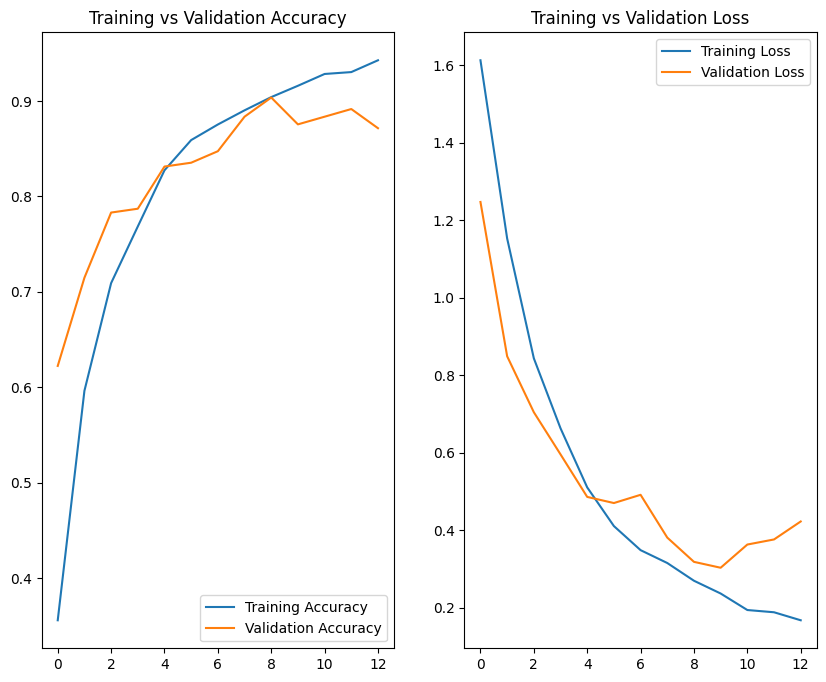

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

In [27]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 983ms/step - accuracy: 0.8799 - loss: 0.3172
Test accuracy is0.8711, Test loss is 0.3407


In [28]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)
y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 896ms/step
[[50  0  1  4  0  0]
 [ 0 40  6  0  3  0]
 [ 0  1 30  0  1  0]
 [ 2  0  2 57  0  3]
 [ 0  0  5  0 40  2]
 [ 1  0  0  2  0  6]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        55
           1       0.98      0.82      0.89        49
           2       0.68      0.94      0.79        32
           3       0.90      0.89      0.90        64
           4       0.91      0.85      0.88        47
           5       0.55      0.67      0.60         9

    accuracy                           0.87       256
   macro avg       0.83      0.85      0.83       256
weighted avg       0.89      0.87      0.87       256



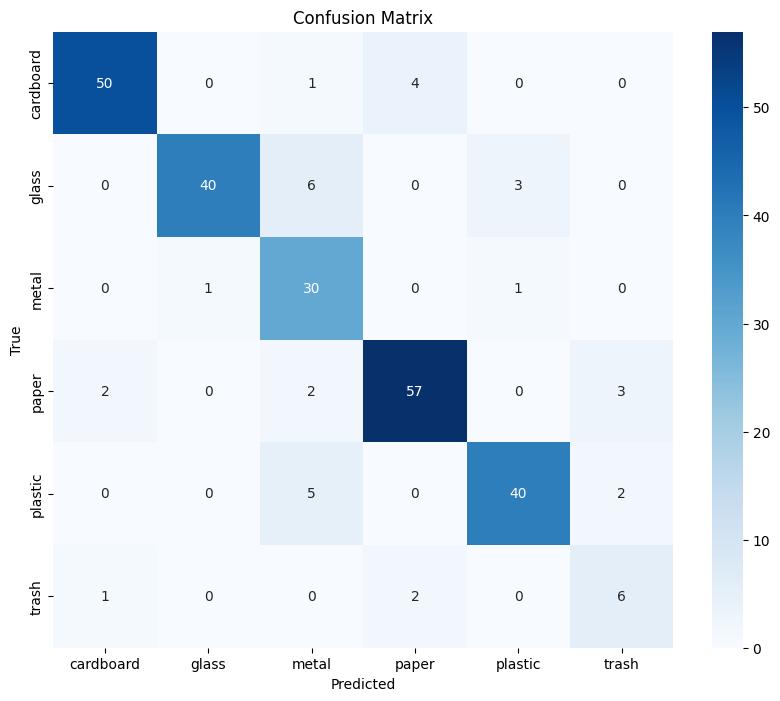

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


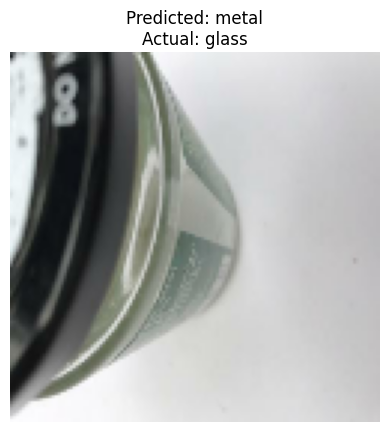

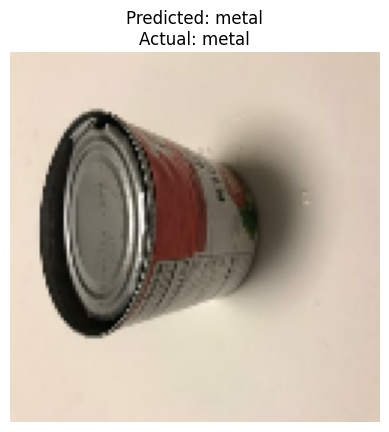

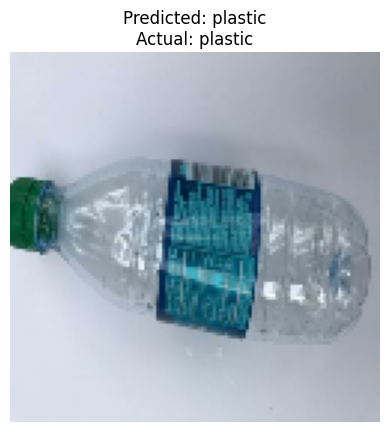

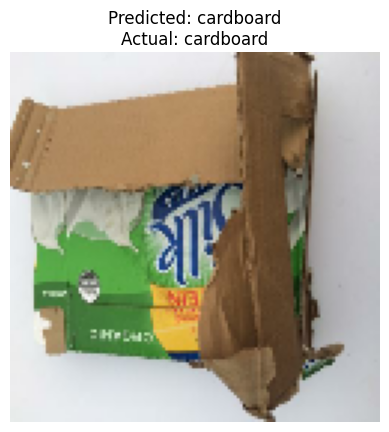

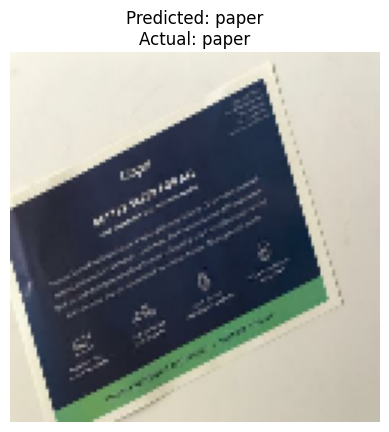

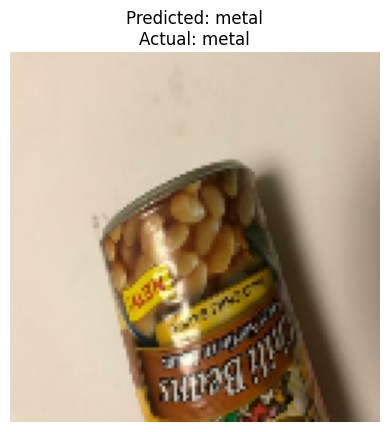

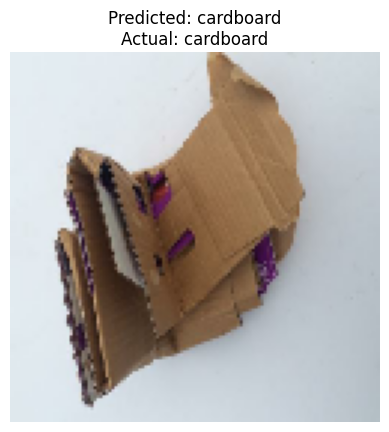

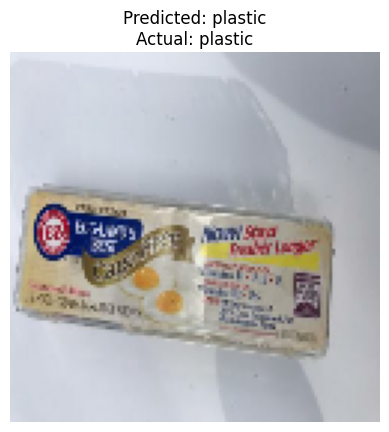

In [30]:
class_names=train_ds.class_names
for images, labels in test_ds.take(1):
  predictions = model.predict(images)
  pred_labels=tf.argmax(predictions, axis=1)

  for i in range(8):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {class_names[pred_labels[i]]}\nActual: {class_names[labels[i]]}")
    plt.axis("off")
    plt.show()

In [31]:
model.save('EfficientNetV2B2.keras')

model=tf.keras.models.load_model('EfficientNetV2B2.keras')

In [48]:
!pip install gradio

In [32]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [33]:
def classify_image(img):
    img = img.resize((124, 124))
    img_array = np.array(img, dtype=np.float32)
    #img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"


In [34]:
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=gr.Text(label="Prediction"),
    live=True
)
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a75594d5ac3ab35509.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
